# Section 1: Installation and Setup

In [57]:
!pip install biopython

In [58]:
from Bio import GenBank
from Bio import Align
import csv
import numpy as np
import pandas as pd
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve)
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Update the filepaths accordingly:

In [60]:
# ecoli.gb source: NCBI: https://www.ncbi.nlm.nih.gov/nuccore/U00096.3?report=genbank&to=4641652
# transcription_unit_data.csv source: RegulonDB: https://regulondb.ccg.unam.mx/datasets/browser/RDBECOLIDLF00010
# protein_families.csv source: UniProt: https://www.uniprot.org/uniprotkb?query=%28taxonomy_id%3A83333%29
ecoli_genbank_filepath = "/content/drive/My Drive/CS 690U/project/ecoli.gb"
ecoli_tu_csv_filepath = "/content/drive/My Drive/CS 690U/project/transcription_unit_data.csv"
protein_families_filepath = "/content/drive/My Drive/CS 690U/project/protein_families.csv"

# Section 2: Data Preparation

In [61]:
# Parse GenBank file to get features (entries)
features = []
with open(ecoli_genbank_filepath, mode='r') as handle:
    record = next(GenBank.parse(handle))
    features = record.features

# Extract gene data from each feature. Includes gene name, location, AA sequence, and DNA strand (+ or -)
genes = []
for feature in features[1:]:
  qualifiers = feature.qualifiers
  gene_dict = {k: v for d in qualifiers for k, v in [(d.key, d.value)]}
  gene_dict["key"] = feature.key
  gene_dict["location"] = feature.location
  genes.append(gene_dict)
genes = [g for g in genes if g["key"] == "CDS"]
for g in genes:
  g["/gene="] = g["/gene="].strip('"') if "/gene=" in g else None
  g["/translation="] = g["/translation="].strip('"').replace("U", "C") if "/translation=" in g else None
  g["strand"] = "+"
  if "complement" in g["location"]:
    g["location"] = g["location"][11:-1]
    g["strand"] = "-"
  g["location"] = g["location"].split("..") if "location" in g else None
  if len(g["location"]) != 2:
    g["location"] = None
  g["location"] = [int(l) for l in g["location"]] if g["location"] != None else None

# Add transcription unit data for each gene. Used as labels for logisitic regression model
transcription_units = []
with open(ecoli_tu_csv_filepath, mode ='r') as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
    transcription_units.append(lines)
for gene in genes:
  name = gene["/gene="]
  for tu in transcription_units:
    gene_list = tu[2].split(";")
    for g in gene_list:
      if name == g:
        gene["tu"] = tu[1]
        break

# Add protein family data for each gene. Used as a feature to predict functional relatedness
protein_families = []
with open(protein_families_filepath, mode ='r') as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
    protein_families.append([lines[1].split(" ")[0], [i for i in lines[2].split(",") if i != '']])
for gene in genes:
  name = gene["/gene="]
  for p in protein_families:
    if p[0] == name:
      gene["families"] = p[1]
      break

# Create table where each row is a pair of AA sequences with data for each sequence. If the genes are on the same transcription unit, the row is labeled 1, else 0.
# Table kept as a Python array instead of a pandas DataFrame to improve speed for feature engineering section.
gene_pair_data = []
for g1, g2 in itertools.combinations(genes, 2):
  g1_name = g1["/gene="] if "/gene=" in g1 else None
  g1_start = g1["location"][0] if g1["location"] != None else None
  g1_stop = g1["location"][1] if g1["location"] != None else None
  g1_strand = g1["strand"] if "strand" in g1 else None
  g1_translation = g1["/translation="] if "/translation=" in g1 else None
  g1_families = g1["families"] if "families" in g1 and len(g1["families"]) > 0 else None
  tu1 = g1["tu"] if "tu" in g1 else None

  g2_name = g2["/gene="] if "/gene=" in g2 else None
  g2_start = g2["location"][0] if g2["location"] != None else None
  g2_stop = g2["location"][1] if g2["location"] != None else None
  g2_strand = g2["strand"] if "strand" in g2 else None
  g2_translation = g2["/translation="] if "/translation=" in g2 else None
  g2_families = g2["families"] if "families" in g2 and len(g2["families"]) > 0 else None
  tu2 = g2["tu"] if "tu" in g2 else None

  gene_pair_data.append([g1_name, g1_start, g1_stop, g1_strand, g1_translation, g2_name, g2_start, g2_stop, g2_strand, g2_translation, 1 if tu1 == tu2 else 0, g1_families, g2_families])

print(len(gene_pair_data))

9320403


# Section 3: Feature Engineering

In [62]:
matrix = Align.substitution_matrices.load("BLOSUM62")
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = matrix

# Add features for each AA pair. Includes: number of shared protein families, ratio of shared protein families to the union of shared familes,
# binary value indicating if the sequences are on the same strand, and the distance between each sequence. If the sequences are on opposite strands,
# the distance is set to a very large value.
feature_matrix = [] # shape: (num_AA_pairs, num_features)
for pair in gene_pair_data:
  if not all([v is not None for v in pair]):
    continue
  features = []
  g1strand = pair[3]
  seq1 = pair[4]
  g2strand = pair[8]
  g1st = pair[1]
  g1stp = pair[2]
  g2st = pair[6]
  g2stp = pair[7]
  seq2 = pair[9]
  g1fs = pair[11]
  g2fs = pair[12]

  g1fs_set = set(g1fs)
  g2fs_set = set(g2fs)
  features.append(float(len(g1fs_set & g2fs_set)))
  features.append(float(len(g1fs_set & g2fs_set)) / float(len(g1fs_set | g2fs_set)))

  if g1strand == g2strand == "+":
    if g1st <= g2st:
      dist = abs(g2st-g1stp)
      features.append(1)
      features.append(dist)
    else:
      dist = abs(g1st-g2stp)
      features.append(1)
      features.append(dist)
    #score = aligner.score(seq1, seq2)
    #features.append(np.log(score))
  elif g1strand == g2strand == "-":
    if g1st >= g2st:
      dist = abs(g2st-g1stp)
      features.append(1)
      features.append(dist)
    else:
      dist = abs(g1st-g2stp)
      features.append(1)
      features.append(dist)
    #score = aligner.score(seq1, seq2)
    #features.append(np.log(score))
  else:
    dist = 10**6
    features.append(0)
    features.append(dist)
    if g1strand == "+":
      score = -1.0
      #score = aligner.score(seq1, seq2, strand="-")
      #features.append(np.log(score))
    else:
      score = -1.0
      #score = aligner.score(seq2, seq1, strand="-")
      #features.append(np.log(score))

  feature_matrix.append(features)

# Section 4: Logistic Regression Model

In [63]:
# X = features, y = labels. Using scikit-learn Logistic Regression module
X = np.array(feature_matrix)
y = np.array([p[-3] for p in gene_pair_data if all([v is not None for v in p])])

print(np.shape(X)) # shape: (num_AA_pairs, num_features)
print(np.shape(y)) # shape: (num_AA_pairs,)

model = LogisticRegression()
model.fit(X,y)

r_a_score = roc_auc_score(y, model.predict_proba(X)[:,1])
ap_score = average_precision_score(y, model.predict_proba(X)[:,1])

print("AUC score: ", r_a_score)
print("AP score: ", ap_score)

(4459591, 4)
(4459591,)
AUC score:  0.9723234476605396
AP score:  0.5266810505899874


# Section 5: Data Visualization

In [64]:
# Create pandas DataFrame for features
feature_cols = ["protein_family_intersection", "protein_family_intersection_over_union", "same_strand", "distance"]
features_df = pd.DataFrame(X, columns=feature_cols)
features_df["tu"] = y

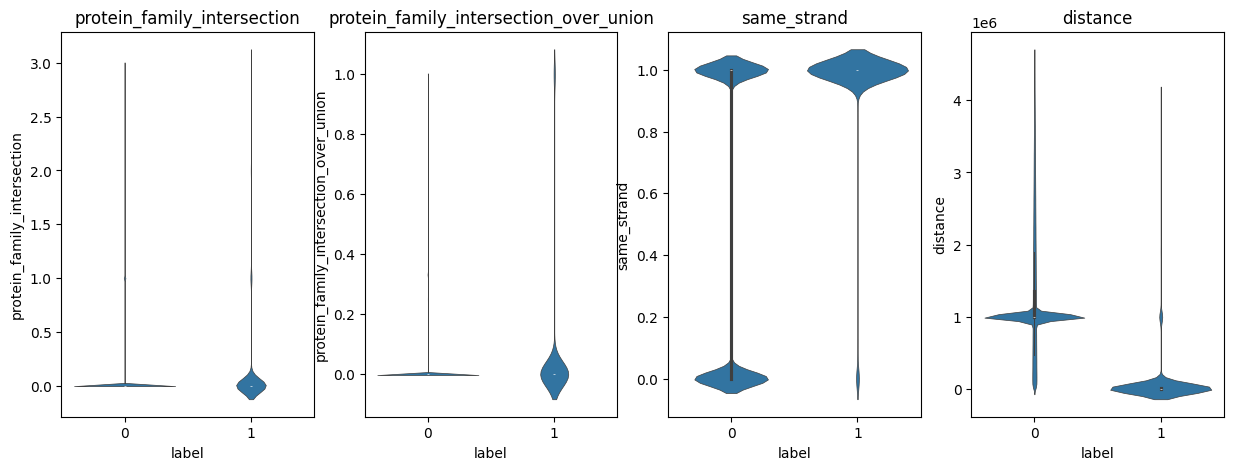

In [68]:
# Violinplots for each feature to view distributions
plt.figure(figsize=(15, 5))
for i, feature in enumerate(feature_cols):
    plt.subplot(1, len(feature_cols), i + 1)
    sns.violinplot(x='tu', y=feature, data=features_df, linewidth=0.5)
    plt.title(feature)
    plt.xlabel('label')
    plt.ylabel(feature)
plt.show()

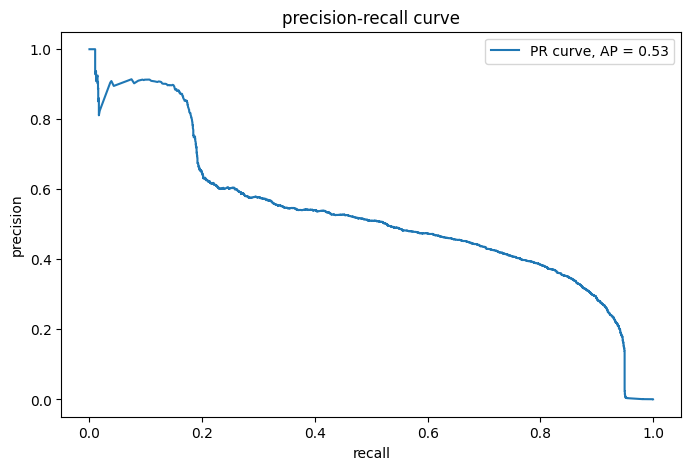

In [69]:
# Precision-recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y, model.predict_proba(X)[:,1])
plt.figure(figsize=(8, 5))
plt.plot(recall_vals, precision_vals, label=f'PR curve, AP = {ap_score:.2f}')
plt.title('precision-recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()